In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install -q transformers[torch] sentencepiece

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:

from transformers import T5ForConditionalGeneration, T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("google/mt5-base")
model = T5ForConditionalGeneration.from_pretrained('google/mt5-base')

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [ ]:
tokenizer.vocab_size

250100

In [ ]:
def msize(m):
    return sum(p.numel() for p in m.parameters())

original_size = msize(model)
print(msize(model))
print(msize(model.shared))
print('encoder')
print(msize(model.encoder))
print(msize(model.encoder.block))
print('decoder')
print(msize(model.decoder))
print(msize(model.decoder.block))
print(msize(model.lm_head))

582401280
192086016
encoder
277040256
84953472
decoder
305361024
113274240
192086016


In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 300
import csv
fname = '/content/gdrive/MyDrive/nep-np_web_2015_1M-sentences.txt'
df_ne = pd.read_csv(fname, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_ne.columns = ['idx', 'text']
df_ne.sample(5)

,idx,text
825558,825559,लण्डनको इसेक्समा निर्माण गरिने केन्द्रमा प्रशोधित ५ लाख ७५ हजार फोहोरलाई १ लाख २० हजार टन स्वच्छ तरल इन्धनमा परिवर्तन गर्न सक्ने क्षमता रहनेछ ।
193118,193119,"आलोचनात्मक टिप्पणी कोशी, गण्डकी, महाँकाली सन्धिहरूमा सुधार हुन सकेन तर पश्चिम सेतीमा सरकारले केही सुधार्‍यो भने संसदीय समितिले उत्कृष्टता दियो।"
990845,990846,हाल जङ्गली कुरिलोको प्रशोधित बीउ प्रतिकेजी रू.
780434,780435,यी दुई देशबीच प्रतिरक्षाका क्षेत्रमा कुनै निर्णय नै भएको नभएपनि आगामी दिनमा यी दुई देशबीचको वार्तालाई निरन्तरता दिने विषयमा भने सहमति भएको बताइएको छ ।
845731,845732,"विकासका आधारभूत तत्व भनेको जमीन, श्रम र पूँजी हुन् ।"


In [ ]:
fname = '/content/gdrive/MyDrive/eng_news_2015_1M-sentences.txt'
df_en = pd.read_csv(fname, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_en.columns = ['idx', 'text']
df_en.sample(5)

,idx,text
698630,698631,The company faces more than 200 civil lawsuits over the ignition switch and other recalls from 2014.
457229,457230,"Lebanese protest Lebanese protesters clash with riot police during a protest in Martyr square, Downtown Beirut, October 8, 2015."
683314,683315,The atlas includes maps of British military campaigns and a 1777 plan of New York City showing much of the settlement clustered at Manhattan's southern tip and farmland covering the rest of the island.
809410,809411,"The text drafted by Chad, Nigeria and Cameroon, and obtained by Reuters, has not yet been circulated to the 15 Security Council members."
205304,205305,"""Eddie is pretty much like our whole football team - he's beat up,"" McCarthy said in his day-after-game news conference."


In [ ]:
from collections import Counter
from tqdm.auto import tqdm, trange

cnt_ne = Counter()
for text in tqdm(df_ne.text):
    cnt_ne.update(tokenizer.encode(text))

cnt_en = Counter()
for text in tqdm(df_en.text):
    cnt_en.update(tokenizer.encode(text))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/965710 [00:00<?, ?it/s]

In [ ]:
print(len(cnt_ne), len(cnt_ne)/tokenizer.vocab_size)
print(len(cnt_en), len(cnt_en)/tokenizer.vocab_size)
common = len(set(cnt_ne.keys()).intersection(set(cnt_en.keys())))
print(common, common / len(cnt_ne))

11427 0.04568972411035586
69637 0.2784366253498601
7771 0.6800560077010589


In [ ]:
print('ne')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_ne.most_common(top)) / sum(cnt_ne.values()))
print('en')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_en.most_common(top)) / sum(cnt_en.values()))

ne
10000 0.9999637115381085
20000 1.0
30000 1.0
en
10000 0.9527348728247316
20000 0.9839953958646229
30000 0.9935862779734062


In [ ]:
old_voc = tokenizer.get_vocab()
old_inv_voc = {v: k for k, v in old_voc.items()}

In [ ]:
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_ne.most_common(30)]))
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_en.most_common(30)]))

['▁', '</s>', '।', 'को', 'मा', 'ले', 'र', 'न', 'ने', '▁आ', '▁छ', ',', '▁भ', 'का', '▁अ', '▁गर', 'एको', '▁स', 'ेको', 'य', 'लाई', '.', 'नी', 'पनि', 'क', '▁उ', 'ी', 'ि', '▁त', '▁प्र']
['▁', '▁the', '</s>', '.', ',', 's', '▁to', 'a', '▁of', '▁and', '▁in', "'", 'ed', '-', '▁that', '▁for', 'ing', '▁is', '▁on', '▁"', '▁The', '▁was', '▁said', '▁with', 'y', '▁it', 'ly', 'd', '▁at', 'e']


In [ ]:
new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_en.most_common(10_000)):
    if k not in new_tokens:
        new_tokens.add(k)
for i, (k, v) in enumerate(cnt_ne.most_common(25_000)):
    if len(new_tokens) == 29_900:
        print(i, 'Nepali tokens are included')
        break
    if k not in new_tokens:
        new_tokens.add(k)

for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)

print(len(new_tokens))
kept_ids = sorted(new_tokens)

18848


In [ ]:
len(kept_ids) / tokenizer.vocab_size

0.07536185525789685

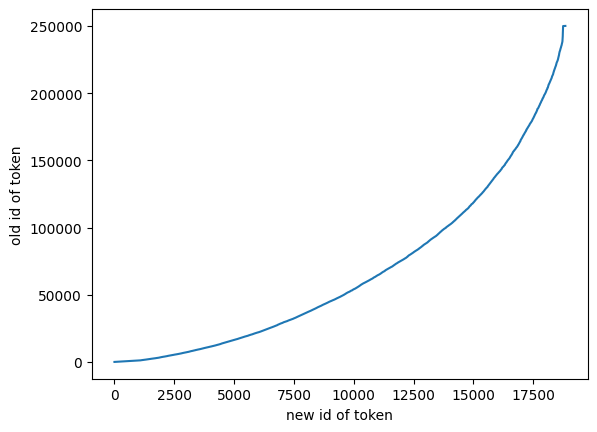

In [ ]:
import matplotlib.pyplot as plt
plt.plot(kept_ids)
plt.xlabel('new id of token')
plt.ylabel('old id of token');

In [ ]:
import torch

new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)

In [ ]:
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]

In [ ]:
model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight

In [ ]:
print(msize(model), msize(model) / original_size)

227179776 0.39007430752899447


In [ ]:
!wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto

--2024-02-08 16:32:30--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14023 (14K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.69K  --.-KB/s    in 0s      

2024-02-08 16:32:30 (78.0 MB/s) - ‘sentencepiece_model.proto’ saved [14023/14023]



In [ ]:
! protoc --python_out=. sentencepiece_model.proto

In [ ]:
import sentencepiece_model_pb2 as spmp
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)

print('The loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('The new pieces:', len(new_pieces))

# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type

# drop the remaining pieces
n = len(new_pieces)
for i in trange(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)

print(len(m.pieces))
with open('new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())

The loaded model has pieces: 250100
The new pieces: 18848


  0%|          | 0/231252 [00:00<?, ?it/s]

18848


In [ ]:
new_tokenizer = T5Tokenizer('new_sp.model', extra_ids=0)

In [ ]:
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = 'cointegrated/net5-base'
model.config

T5Config {
  "_name_or_path": "cointegrated/net5-base",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.35.2",
  "use_cache": true,
  "vocab_size": 18848
}

In [ ]:
new_tokenizer.save_pretrained('/content/drive/MyDrive/net5-base')
model.save_pretrained('/content/drive/MyDrive/net5-base')

In [ ]:
!ls net5-base -alsh

total 868M
4.0K drwxr-xr-x 2 root root 4.0K Feb  8 16:35 .
4.0K drwxr-xr-x 1 root root 4.0K Feb  8 16:37 ..
4.0K -rw-r--r-- 1 root root  831 Feb  8 16:35 config.json
4.0K -rw-r--r-- 1 root root  142 Feb  8 16:35 generation_config.json
867M -rw-r--r-- 1 root root 867M Feb  8 16:35 model.safetensors
4.0K -rw-r--r-- 1 root root  416 Feb  8 16:35 special_tokens_map.json
572K -rw-r--r-- 1 root root 569K Feb  8 16:35 spiece.model
4.0K -rw-r--r-- 1 root root  833 Feb  8 16:35 tokenizer_config.json


In [ ]:
model1 = T5ForConditionalGeneration.from_pretrained('net5-base')
tokenizer1 = T5Tokenizer.from_pretrained('net5-base')

In [ ]:
inputs = tokenizer1('संक्षेप गर्नुहोस्: नेपालमा पर्यटन उद्योग अत्यन्त महत्वपूर्ण र विकासको एक मुख्य आधार हो। नेपालको सुन्दर प्राकृतिक सौंदर्य, विविधता, ऐतिहासिक स्थलहरू, विविध सांस्कृतिक विरासत, त्योहार र विविध जात्रा स्थलहरूले पर्यटकहरूलाई आकर्षित गर्दछ। साथै, नेपाली र सांस्कृतिक परिमाणमा धेरै पर्यटकहरूको ध्यान आकर्षित गर्दछ। पर्यटनले नेपालमा रोजगार, आर्थिक वृद्धि, औद्योगिक विकास, राष्ट्रिय आय र पर्यटन संरक्षणको लागि एक महत्त्वपूर्ण योगदान गर्दछ।', return_tensors='pt', max_length=1024, padding=True, Truncation=True)
with torch.no_grad():
    hypotheses = model1.generate(
        **inputs,
        do_sample=True, top_p=0.95,
        num_beams=10,
        num_return_sequences=1,
        repetition_penalty=2.5,
        length_penalty=2,
        min_length=32,
        max_length=64,
    )
for h in hypotheses:
    print(tokenizer1.decode(h))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2632: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Keyword arguments {'Truncation': True} not recognized.


<pad><extra_id_0> नेपाली भाषामा लेख्न सकिन्छ। <extra_id_1> नेपालमा पर्यटन उद्योग कस्तो हो? <extra_id_2>: <extra_id_3>: <extra_id_4>: <extra_id_17>: <extra_id_18> तथा सम्पत्ति: <extra_id_42>,  <extra_id_55>: <extra_id_56> (२०७५ जुलाई १८ गते) मा प्रकाशित, “नेपालको पर्यटकीय
